# Data Processing Notebook - Elliptic Dataset Analysis

> Import all libraries

In [1]:
import random

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

import networkx as nx

import pickle

import matplotlib.pyplot as plt

___

### First, load the data and remove useless information.

> I will be removing all nodes that are classified as `unknown` in all three datasets.

In [2]:
classesDF  = pd.read_csv('../../data/elliptic_txs_classes.csv')

# Remove all nodes that have unknown class
classesDF = classesDF[classesDF['class'] != "unknown"]

# If class = 2, then map to 0, else map to 1
classesDF['class'] = classesDF['class'].map({'2': 0, '1': 1})

In [15]:
classes_dist = (classesDF['class'] == 0).sum(), (classesDF['class'] == 1).sum()

print(f'Class distribution: \n \
      {classes_dist[0]} licit transactions \n \
      {classes_dist[1]} illicit transactions')

Class distribution: 
       42019 licit transactions 
       4545 illicit transactions


In [6]:
edgelistDF = pd.read_csv('../../data/elliptic_txs_edgelist.csv')

# Remove all edges that do not appear in classesDF
edgelistDF = edgelistDF[edgelistDF['txId1'].isin(classesDF['txId'])]
edgelistDF = edgelistDF[edgelistDF['txId2'].isin(classesDF['txId'])]

In [7]:
featuresDF = pd.read_csv('../../data/elliptic_txs_features.csv')

# Change column names --> Column 1 is txId, Column 2 is timestep and the rest are unknown features
featuresDF.columns = ['txId', 'timestep'] + ['f' + str(i) for i in range(165)]

# Remove all edges that do not appear in classesDF
featuresDF = featuresDF[featuresDF['txId'].isin(classesDF['txId'])]

___

### First idea: reduce the data dimensions with PCA. 
 
> Compute the `Principal Component Analysis` of the `featuresDF` dataframe. This will help reducing the dimensions of the data helping in more efficiency.


***Editor's Idea:***
```
Since the dataset does not any specific variable name, they don't represent any feature directly. This way, we can try to summarize all the information in less dimensions thanks to PCA. this way, we will have the same information in less space and without losing any information we had before (we basically didn't have any.)
```

In [8]:
# Compute PCA on the features
pca = PCA()
pca.fit(featuresDF.iloc[:, 2:]) # Ignore the first column (txId)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Set a threshold of 95% variance explained
n_components_for_95_variance = np.argmax(cumulative_variance_ratio >= 0.99) + 1

print("Number of components to explain 99% of variance:", n_components_for_95_variance)

Number of components to explain 99% of variance: 71


In [9]:
# Fit PCA with the number of components that explain 95% of variance
pca = PCA(n_components=n_components_for_95_variance)
pca.fit(featuresDF.iloc[:, 2:])  # Assuming first column is not a variable

# Transform the data to the new PCA space
features_pca = pca.transform(featuresDF.iloc[:, 2:])

# If you want to see the explained variance ratio of each component
variance_ratios_str = ', '.join(map(str, pca.explained_variance_ratio_))
print("Explained variance ratio of each component:", variance_ratios_str)

featuresDF.reset_index(drop=True, inplace=True)
featuresDF = pd.concat([featuresDF['txId'], featuresDF['timestep'], pd.DataFrame(features_pca)], axis=1) # Add the transformed features to the dataframe

Explained variance ratio of each component: 0.1447251116657139, 0.06749281533592895, 0.061235685888443386, 0.0573887537030309, 0.042434486833099215, 0.03779401840538326, 0.03515124987161215, 0.03094557795556129, 0.02853078493513596, 0.024306502232863993, 0.021638671097537223, 0.020923091697641363, 0.020093727936086315, 0.019239727244653632, 0.01907775993993298, 0.01816118347524441, 0.01772299023811136, 0.01654881350036026, 0.015921876308726535, 0.015030802553902399, 0.013751416222523573, 0.013482390829813683, 0.01313416084240115, 0.012641196856655313, 0.012346860811642844, 0.010749846933590013, 0.010383005521288494, 0.010006079017252907, 0.009510389253588051, 0.009290518555350385, 0.008874546861043433, 0.00844130462192056, 0.008273014691034905, 0.00784093719275902, 0.00775176520262273, 0.006617437700318141, 0.00628801471353831, 0.005896323976130422, 0.005761313939628485, 0.005476945258483579, 0.005270898174788471, 0.005029828153607849, 0.0050095592691707744, 0.004700045068019144, 0.004

In [10]:
# Store PCA weights
with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

___

### Now, load the data into a NetworkX directed graph and compute several statistics.
 
> All `txId`s from `classesDF` will be represening nodes and the edges will come from `edgelistDF`. 

The indegree and outdegree values of each node will be appended as the node property.

In [11]:
# Initialize a directed graph
graph = nx.DiGraph()

# Add nodes and edges based on the DataFrames
graph.add_nodes_from(classesDF['txId'])
graph.add_edges_from(edgelistDF.values)

for node in graph.nodes():
    graph.nodes[node]['indegree'] = graph.in_degree(node)
    graph.nodes[node]['outdegree'] = graph.out_degree(node)

Compute generic statistics such as centralities and and clustering coefficients.

In [12]:
# Set general statistics as node attributes
###########################################################
# IMPOSSIBLE TO COMPUTE -- VERY BIG NETWORK
###########################################################
# bc = nx.betweenness_centrality(graph)
# nx.set_node_attributes(graph, bc, 'betweenness_centrality')  
###########################################################

# Compute degree centrality for all nodes
degree_centrality = nx.degree_centrality(graph)
nx.set_node_attributes(graph, degree_centrality, 'degree_centrality')

# Compute clustering coefficient for all nodes
clustering_coefficient = nx.clustering(graph)
nx.set_node_attributes(graph, clustering_coefficient, 'clustering_coefficient')

# Compute closeness centrality for all nodes
closeness_centrality = nx.closeness_centrality(graph)
nx.set_node_attributes(graph, closeness_centrality, 'closeness_centrality')

# Compute eigenvector centrality for all nodes
eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
nx.set_node_attributes(graph, eigenvector_centrality, 'eigenvector_centrality')

The dataframe `featuresDF` contains each node's data. This will be included in each of the nodes' properties.

In [13]:
# Set the properties of each node (from featuresDF)
for index, row in featuresDF.iterrows():
    node_id = row['txId']  # Assuming 'txId' is the common node identifier
    # Drop the 'txId' column and convert the remaining row to a dictionary
    node_attributes = row.drop('txId').to_dict()
    # Update the node attributes in the graph
    graph.nodes[node_id].update(node_attributes)

In [14]:
# Observe random node properties
random_node = graph.nodes[random.choice(list(graph.nodes))]
print(random_node)

{'indegree': 1, 'outdegree': 0, 'degree_centrality': 2.1476279449348196e-05, 'clustering_coefficient': 0, 'closeness_centrality': 2.1476279449348196e-05, 'eigenvector_centrality': 8.078292500012373e-111, 'timestep': 33.0, 0: -3.6106925812678377, 1: -0.3056510864517402, 2: 0.5097263954320468, 3: 0.658540400712386, 4: -1.0570185352621706, 5: -1.1189731583584839, 6: -1.2435497667030904, 7: -0.04481197924601406, 8: -1.3536452545134747, 9: -1.8870492230523686, 10: -0.735117135930657, 11: -0.08169981305203398, 12: -0.18997775008977122, 13: 0.664908035795237, 14: 0.7913307792304212, 15: -0.37540540416492973, 16: 0.1643501351264508, 17: -0.20143676056102386, 18: 0.7944147294469976, 19: 0.8580243138467383, 20: 0.26753195284048326, 21: -0.13489364937163234, 22: 0.00783960776776422, 23: 0.0698180436557573, 24: -0.11090115820447839, 25: 0.16896693130494925, 26: 1.3759684226713869, 27: 0.4085895234444731, 28: 0.6829362330796204, 29: -0.411855574259981, 30: -0.7006450220332776, 31: -0.03270544536502

____

### Some plots and displays to understand better the dataset

##### General information about the graph

In [15]:
# Display graph dimension
print(f"The graph has {graph.order()} nodes and {graph.size()} edges.\n")

# Compute assortativity coefficient
assortativity = nx.degree_assortativity_coefficient(graph)
print(f'Assortativity value: {assortativity}. \nThis means that the graph is not assortative at all.\n')

# Compute graph Density
density = nx.density(graph)
print(f'Graph density: {density}. \nThis means that the graph is not dense at all.\n')

The graph has 46564 nodes and 36624 edges.

Assortativity value: -0.07547351098636665. 
This means that the graph is not assortative at all.

Graph density: 1.6891745952944943e-05. 
This means that the graph is not dense at all.



##### Degree Distribution representation and information.

Maximum degree: 453
Minimum degree: 0
The average degree of the graph is 1.5730607336139506.


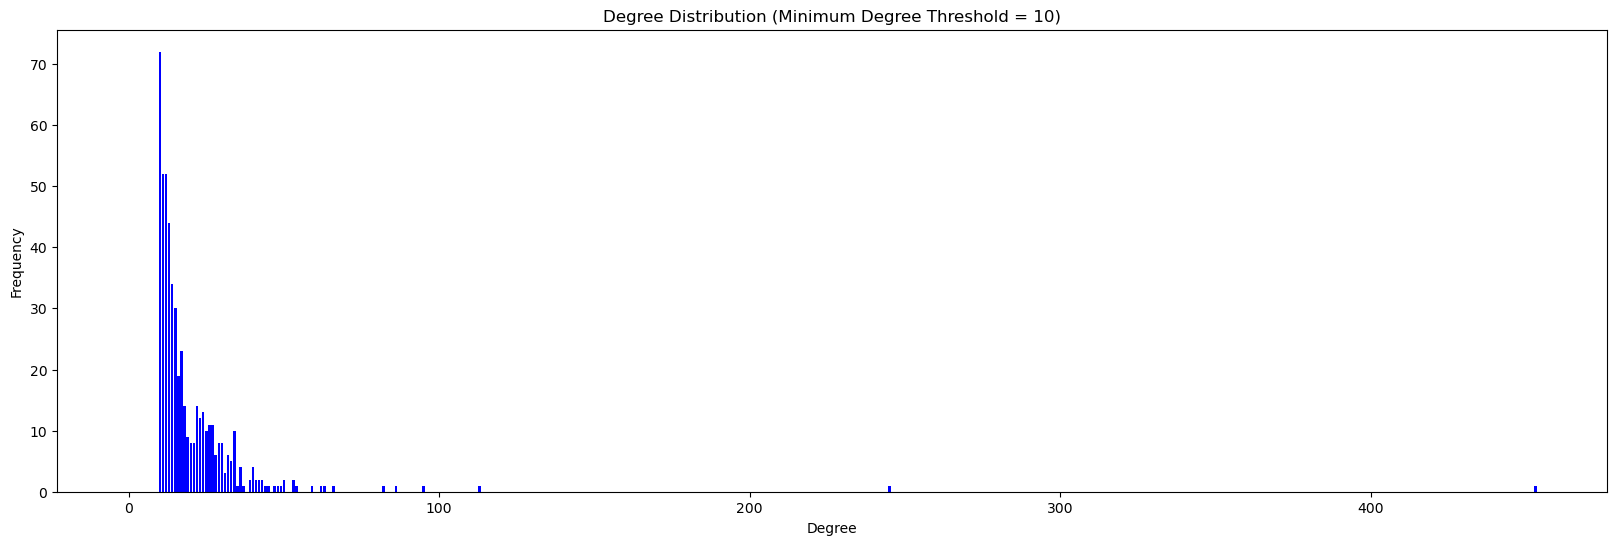

In [16]:
# Compute the degrees of all nodes in the graph
degrees = dict(graph.degree())

# Find the maximum degree
max_degree = max(degrees.values())
min_degree = min(degrees.values())
print("Maximum degree:", max_degree)
print("Minimum degree:", min_degree)

# Compute degree distribution as histogram
degree_distribution = nx.degree_histogram(graph)
average_degree = sum(deg * cnt for deg, cnt in enumerate(degree_distribution)) / graph.number_of_nodes()
print(f'The average degree of the graph is {average_degree}.')

# Set the threshold for minimum degree
threshold = 10

# Filter out degrees below the threshold
filtered_degree_distribution = [count if degree >= threshold else 0 for degree, count in enumerate(degree_distribution)]

# Plotting the histogram
plt.figure(figsize=(20, 6))
plt.bar(range(len(filtered_degree_distribution)), filtered_degree_distribution, color='b')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Minimum Degree Threshold = 10)')
plt.show()